# Master Thesis (Electricity Trading on Intraday Market in Japan)

# Read & interpret dataset

Loading some datasets <p>
Confirming and interpreting it <p>
Preprocessing missing values and outliers on the datasets

In [1]:
# Import modules
import pandas as pd
import matplotlib.pyplot as plt #描画ライブラリ
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import pathlib
import glob
import math
import statsmodels.api as sm
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import datetime


# Show all the rows and columns up to 200
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

## JEPX_Intra_datasets
http://www.jepx.org/market/index.html

In [2]:
# read the dataset (Here, these are re-organised after getting the latest dataset)

#Intra_dataset
df_intra_2016 = pd.read_csv('/Users/kenotsu/Documents/master_thesis/Datasets/Master_thesis/im_trade_summary_2016.csv', sep=',', header=0, encoding='shift_jis')
df_intra_2017 = pd.read_csv('/Users/kenotsu/Documents/master_thesis/Datasets/Master_thesis/im_trade_summary_2017.csv', sep=',', header=0, encoding='shift_jis')
df_intra_2018 = pd.read_csv('/Users/kenotsu/Documents/master_thesis/Datasets/Master_thesis/im_trade_summary_2018.csv', sep=',', header=0, encoding='shift_jis')
df_intra_2019 = pd.read_csv('/Users/kenotsu/Documents/master_thesis/Datasets/Master_thesis/im_trade_summary_2019.csv', sep=',', header=0, encoding='shift_jis')
df_intra_2020 = pd.read_csv('/Users/kenotsu/Documents/master_thesis/Datasets/Master_thesis/im_trade_summary_2020.csv', sep=',', header=0, encoding='shift_jis')

In [3]:
# marge all the intra datasets
df_intra = pd.concat([df_intra_2016, df_intra_2017])
df_intra = pd.concat([df_intra, df_intra_2018])
df_intra = pd.concat([df_intra, df_intra_2019])
df_intra = pd.concat([df_intra, df_intra_2020])

In [4]:
df_intra = df_intra.rename(columns={'年月日': 'Date', 
                                    '時刻コード': 'HH',
                                    '始値（円/kWh）': 'Open',
                                    '高値（円/kWh）': 'High',
                                    '安値（円/kWh）': 'Low',
                                    '終値（円/kWh）': 'Close',
                                    '平均（円/kWh）': 'Average',
                                    '約定量合計（MWh/h）': 'Volume(MWh/h)',
                                    '約定件数': 'Volume(Tick count)'})

In [5]:
# # Apply to_datetime
df_intra["Date"] = pd.to_datetime(df_intra["Date"])

In [6]:
df_intra.tail()

,Date,HH,Open,High,Low,Close,Average,Volume(MWh/h),Volume(Tick count)
14148,2021-01-20,37,200.00,203.98,150.00,199.30,186.25,1750.4,239
14149,2021-01-20,38,200.00,203.98,49.00,49.00,181.21,1414.0,244
14150,2021-01-20,39,200.00,200.50,49.00,49.00,176.98,1006.9,197
14151,2021-01-20,40,184.24,190.00,69.89,69.89,159.62,781.6,141
14152,2021-01-20,41,200.00,201.00,69.89,69.89,174.45,1036.4,150


In [7]:
df_intra.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84281 entries, 0 to 14152
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                84281 non-null  datetime64[ns]
 1   HH                  84281 non-null  int64         
 2   Open                84209 non-null  float64       
 3   High                84209 non-null  float64       
 4   Low                 84209 non-null  float64       
 5   Close               84209 non-null  float64       
 6   Average             84209 non-null  float64       
 7   Volume(MWh/h)       84209 non-null  float64       
 8   Volume(Tick count)  84281 non-null  int64         
dtypes: datetime64[ns](1), float64(6), int64(2)
memory usage: 6.4 MB


## Half Hourly time slot

時間の切上げ切り捨てについて
https://www.deep-rain.com/programming/python/1355#i-4

In [8]:
# Make a table for QH_number
df_intra_HH = df_intra.reset_index()
HH_table = pd.DataFrame(df_intra_HH["HH"])
HH_table = HH_table.drop_duplicates()
HH_table['Time'] = pd.date_range('2020/01/01', periods=48,  freq='30min').strftime('%H:%M')
HH_table['Time'] = HH_table['Time'].str[-8:]
# HH_table['Hourly_Time'] = pd.date_range('2020/01/01', periods=48,  freq='30min').floor("H").strftime('%H:%M')
# HH_table['Hourly_Time'] = pd.to_datetime(HH_table['Hourly_Time']).dt.time

HH_table.head()

,HH,Time
0,1,00:00
1,2,00:30
2,3,01:00
3,4,01:30
4,5,02:00


## Actual_generation(Tohoku_area) ※ "Time"列を使うだけ
https://setsuden.nw.tohoku-epco.co.jp/download.html

In [9]:
#Actual generation_dataset from 2016-08-01
df_actual_generation_1 = pd.read_csv('/Users/kenotsu/Documents/master_thesis/Datasets/Master_thesis/使うかわからない軍/Actual_generation_5min/Actual_generation1.csv', sep=',', header=0, encoding='shift_jis')

#Actual generation_dataset from 2020-04-14
df_actual_generation_2 = pd.read_csv('/Users/kenotsu/Documents/master_thesis/Datasets/Master_thesis/使うかわからない軍/Actual_generation_5min/Actual_generation2.csv', sep=',', header=0, encoding='shift_jis')

df_actual_generation_Tohoku = pd.concat([df_actual_generation_1, df_actual_generation_2])
df_actual_generation_Tohoku = df_actual_generation_Tohoku.rename(columns={'DATE': 'Date', 'TIME': 'Time',
    '太陽光発電実績(5分間隔値)(万kW)': 'gen_Solar(mkW)', '当日実績(5分間隔値)(万kW)': 'gen_all(mkW)', '風力発電実績(5分間隔値)(万kW)': 'gen_Wind(mkW)'
})
df_actual_generation_Tohoku["gen_Solar(mkW)"].fillna(0, inplace=True)
df_actual_generation_Tohoku["gen_all(mkW)"].fillna(0, inplace=True)
df_actual_generation_Tohoku["gen_Wind(mkW)"].fillna(0, inplace=True)
df_actual_generation_Tohoku["DateTime"] = pd.to_datetime(df_actual_generation_Tohoku["Date"] + " " + df_actual_generation_Tohoku["Time"])
df_actual_generation_Tohoku = df_actual_generation_Tohoku.groupby(pd.Grouper(key="DateTime", freq='30min')).sum()
df_actual_generation_Tohoku.reset_index(inplace = True)
df_actual_generation_Tohoku["Time"] = pd.to_datetime(df_actual_generation_Tohoku["DateTime"]).dt.time
df_actual_generation_Tohoku["Date"] = pd.to_datetime(df_actual_generation_Tohoku["DateTime"]).dt.date
df_actual_generation_Tohoku["Date"] = pd.to_datetime(df_actual_generation_Tohoku["Date"])

df_actual_generation_Tohoku = df_actual_generation_Tohoku.drop("DateTime", axis=1)
df_actual_generation_Tohoku.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77472 entries, 0 to 77471
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   gen_all(mkW)    77472 non-null  float64       
 1   gen_Solar(mkW)  77472 non-null  float64       
 2   gen_Wind(mkW)   77472 non-null  float64       
 3   Time            77472 non-null  object        
 4   Date            77472 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 3.0+ MB


# Make all_data

In [10]:
HH_table = pd.DataFrame(df_intra_HH["HH"])
HH_table = HH_table.drop_duplicates()
time = df_actual_generation_Tohoku["Time"]
time = pd.DataFrame(time)
time = time.drop_duplicates()
HH_table["Time"] = time

## Merge all input data

In [11]:
all_data = df_intra

# HH_table
all_data = pd.merge(all_data, HH_table, how="left", on=['HH'])

all_data.head(10)

,Date,HH,Open,High,Low,Close,Average,Volume(MWh/h),Volume(Tick count),Time
0,2016-04-01,1,7.69,7.69,7.69,7.69,7.69,0.7,1,00:00:00
1,2016-04-01,2,NaN,NaN,NaN,NaN,NaN,NaN,0,00:30:00
2,2016-04-01,3,7.21,7.21,7.21,7.21,7.21,0.8,1,01:00:00
3,2016-04-01,4,7.06,7.06,7.06,7.06,7.06,0.8,1,01:30:00
4,2016-04-01,5,7.21,7.21,7.21,7.21,7.21,0.8,1,02:00:00
5,2016-04-01,6,7.21,7.21,7.21,7.21,7.21,0.8,1,02:30:00
6,2016-04-01,7,7.21,7.21,7.21,7.21,7.21,0.8,1,03:00:00
7,2016-04-01,8,7.21,7.21,7.21,7.21,7.21,0.8,1,03:30:00
8,2016-04-01,9,7.06,7.06,7.06,7.06,7.06,0.8,1,04:00:00
9,2016-04-01,10,7.06,7.06,7.06,7.06,7.06,0.8,1,04:30:00


In [12]:
print(all_data.isnull().sum())

Date                   0
HH                     0
Open                  72
High                  72
Low                   72
Close                 72
Average               72
Volume(MWh/h)         72
Volume(Tick count)     0
Time                   0
dtype: int64


In [13]:
# Fillna with the average between the previous and later slots for Price, Weather, Demend
all_data.interpolate(method='linear', inplace=True)

In [14]:
print(all_data.isnull().sum())

Date                  0
HH                    0
Open                  0
High                  0
Low                   0
Close                 0
Average               0
Volume(MWh/h)         0
Volume(Tick count)    0
Time                  0
dtype: int64


In [15]:
# Create a column for "date block num"
all_data['Date'] = pd.to_datetime(all_data['Date'])
all_data["date_block_num"] = np.trunc(all_data['Date'].map(pd.Timestamp.timestamp).astype(int) / 86400 - 16891)

※ Filter all_data from 2016-04-01 to 2020-12-31

In [16]:
all_data = all_data[all_data["Date"] <= "2020-12-31"]

In [17]:
all_data['month'] = pd.to_datetime(all_data["Date"]).dt.month

In [18]:
all_data.head()

,Date,HH,Open,High,Low,Close,Average,Volume(MWh/h),Volume(Tick count),Time,date_block_num,month
0,2016-04-01,1,7.69,7.69,7.69,7.69,7.69,0.70,1,00:00:00,1.0,4
1,2016-04-01,2,7.45,7.45,7.45,7.45,7.45,0.75,0,00:30:00,1.0,4
2,2016-04-01,3,7.21,7.21,7.21,7.21,7.21,0.80,1,01:00:00,1.0,4
3,2016-04-01,4,7.06,7.06,7.06,7.06,7.06,0.80,1,01:30:00,1.0,4
4,2016-04-01,5,7.21,7.21,7.21,7.21,7.21,0.80,1,02:00:00,1.0,4


# Data leakage(Predictionポイントは前日の24:00とする)

# Feature Engineering

## Lag-features (Avoiding data leakage)

※Infinity value will be happen with Downcast preprocessing. ("Total" column)

In [19]:
# Check the remaining memory on PC
import gc
gc.collect()

53

※ ラグ特徴量が必要ないものと"Close"(target)は外す

厳密にすると、17:00〜23:30は予測時点では１日前の情報は手に入らない
Prediction pointを「前日の17:00直前」とする場合は、以下の手当が必要
予測時点の前後でDaylag1とDaylag2の参照を変える
もともとのカラムに格納し、カラム名を変更する
Daylag1とDaylag2を削除する

※一旦は２日ずらして対応する (ただし、Closeとの相関は当然下がるため改善の余地有り)

In [20]:
# This is for generating lag
def generate_lag(train, lag_sizes, cols, lag_sizes_type):

    lag_sizes = np.array(lag_sizes)
    if lag_sizes_type == "HH":
        lag_sizes_adj = lag_sizes * 1 # nothing changes
    elif lag_sizes_type == "Hours":
        lag_sizes_adj = lag_sizes * 2
    elif lag_sizes_type == "Day":
        lag_sizes_adj = lag_sizes * 48

    for ix, lag_sizes_adj_ in enumerate(lag_sizes_adj):
        shifted_df = all_data[cols].shift(lag_sizes_adj_)
        shifted_df.columns = [f"{col_name}_lag_{lag_sizes[ix]}_{lag_sizes_type}" for col_name in shifted_df.columns]
        if ix == 0:
            shifted_df_return = shifted_df
        else:
            shifted_df_return = shifted_df_return.merge(shifted_df, how="left", left_index=True, right_index=True)
    return shifted_df_return

In [22]:
# Drop columns that are not necessary to generate lag features
lag_columns = all_data.columns.drop(['Date', 'Time', 'HH', 'Close', 'date_block_num', 'month'])

# Generate lag features and drop original columns
# all_data_lagged_HH = generate_lag(all_data, [49, 97], lag_columns, "HH")
# all_data_lagged_Hour = generate_lag(all_data, [2], lag_columns, "Hours")
all_data_lagged_Day = generate_lag(all_data, [1, 2], lag_columns, "Day")

# join everything (Be careful of choosing the left dataset)
# all_data_lagged = pd.merge(all_data, all_data_lagged_HH, how="left", left_index=True, right_index=True)
# all_data = pd.merge(all_data, all_data_lagged_Hour, how="left", left_index=True, right_index=True)
all_data_lagged = pd.merge(all_data, all_data_lagged_Day, how="left", left_index=True, right_index=True)

# Drop lag_columns which can be data leakage
all_data_lagged = all_data_lagged.drop(lag_columns, axis=1)

In [23]:
# # Check the lag columns
# temp_col = [item for item in all_data_lagged.columns if item.find('Day') != -1]

# print(temp_col)

In [24]:
print(all_data_lagged.isnull().sum().head(20))

Date                             0
HH                               0
Close                            0
Time                             0
date_block_num                   0
month                            0
Open_lag_1_Day                  48
High_lag_1_Day                  48
Low_lag_1_Day                   48
Average_lag_1_Day               48
Volume(MWh/h)_lag_1_Day         48
Volume(Tick count)_lag_1_Day    48
Open_lag_2_Day                  96
High_lag_2_Day                  96
Low_lag_2_Day                   96
Average_lag_2_Day               96
Volume(MWh/h)_lag_2_Day         96
Volume(Tick count)_lag_2_Day    96
dtype: int64


NaN was generated only on 96 (48 * 2) timeslots on the firstday 2016/04/01　and 2016/04/02 --> OK 

In [25]:
all_data_lagged.fillna(0, inplace=True)
print(all_data_lagged.isnull().sum().head())

Date              0
HH                0
Close             0
Time              0
date_block_num    0
dtype: int64


## Standardise with Log-features (対数化)

[Mission]
対数の逆対数変換をして元の数値を得ること
-->グラフで可視化してみる (Closeと対数化Close)線グラフ
-->逆対数の数式を手動で適用してみる
-->

Skew: 5.771550
Kurt: 75.846330


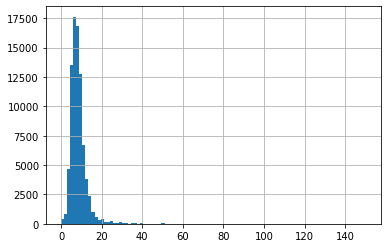

In [26]:
all_data_lagged["Close"].hist(bins=100);
print("Skew: %f" % all_data_lagged["Close"].skew())
print("Kurt: %f" % all_data_lagged["Close"].kurt())

- Positive skew
- High kurt --> Fat tail

In [32]:
cols = all_data_lagged.columns

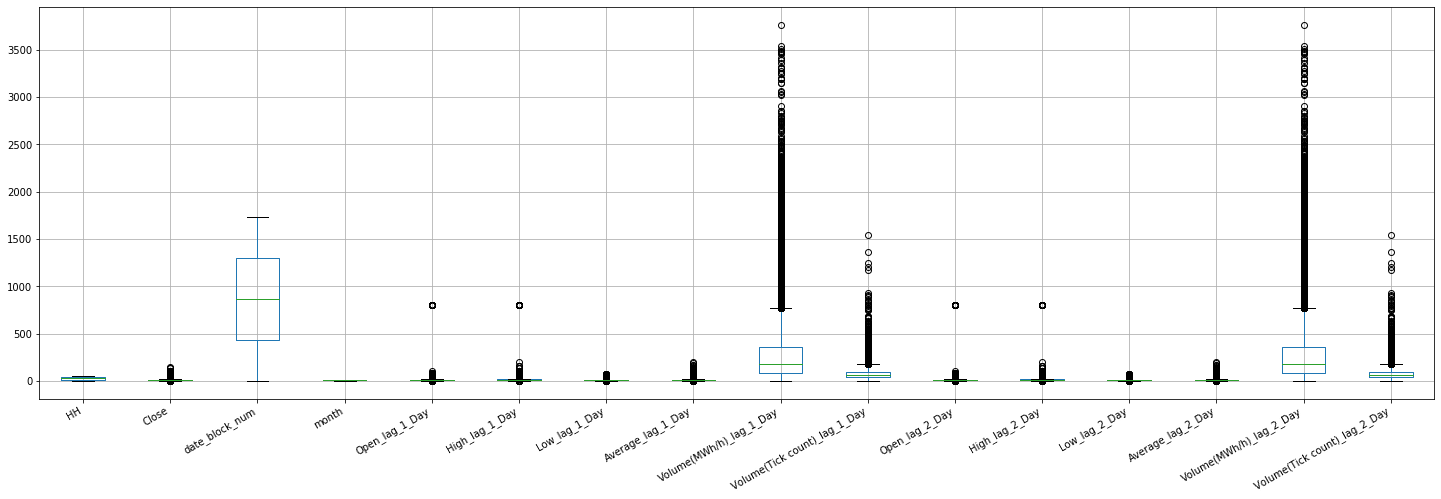

In [34]:
plt.figure(figsize = (25,8))
all_data_lagged[cols].boxplot()
plt.gcf().autofmt_xdate()

plt.show()

Features seem to be positive skew, and have different scale. --> Need to standardise

In [35]:
for i in all_data_lagged:
   print(str(min(all_data_lagged[i])) + "\t" + str(i))

2016-04-01 00:00:00	Date
1	HH
0.01	Close
00:00:00	Time
1.0	date_block_num
1	month
0.0	Open_lag_1_Day
0.0	High_lag_1_Day
0.0	Low_lag_1_Day
0.0	Average_lag_1_Day
0.0	Volume(MWh/h)_lag_1_Day
0.0	Volume(Tick count)_lag_1_Day
0.0	Open_lag_2_Day
0.0	High_lag_2_Day
0.0	Low_lag_2_Day
0.0	Average_lag_2_Day
0.0	Volume(MWh/h)_lag_2_Day
0.0	Volume(Tick count)_lag_2_Day


天気情報がなければ負の値はないが、0を含む特徴量が多い

In [36]:
all_data_lagged1 = all_data_lagged[['Date', 'Time', 'HH', 'date_block_num', 'month']]
all_data_lagged2 = all_data_lagged.drop(['Date', 'Time', 'HH', 'date_block_num', 'month'], axis=1)

In [37]:
# # logarithmic transformation for standardised
# # 0と負の値を含む列があるので、PowerTransformer()のYeo-Johnson変換を適用する (対数変換の一種)
from sklearn.preprocessing import PowerTransformer
def trans_yeo_johnson(df, df2):
    pt = PowerTransformer() #default: Yeo-Johnson (this allow also 0-value to transform to logarithmic value)
    pt.fit_transform(df)
    return pt.transform(df2)

def inverse_trans_yeo_johnson(df, df2):
    pt = PowerTransformer() #default: Yeo-Johnson (this allow also 0-value to transform to logarithmic value)
    pt.fit_transform(df)
    return pt.inverse_transform(df2)

In [38]:
#　対数変換
all_data_log2_transformed = all_data_lagged2.copy()
cols = all_data_log2_transformed.columns

all_data_log2_transformed = trans_yeo_johnson(all_data_lagged2, all_data_log2_transformed)
all_data_log2_transformed = pd.DataFrame(all_data_log2_transformed)
all_data_log2_transformed.columns = cols

In [39]:
all_data_log = pd.concat([all_data_lagged1, all_data_log2_transformed], axis=1)

Skew: 0.016581
Kurt: 5.092394


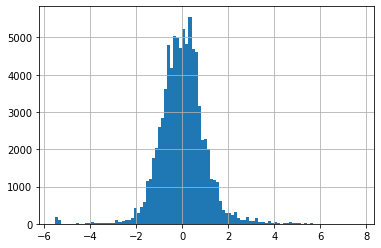

In [40]:
all_data_log["Close"].hist(bins=100);
print("Skew: %f" % all_data_log["Close"].skew())
print("Kurt: %f" % all_data_log["Close"].kurt())

※ Confirm whether inverse transform works appropriately, or not

※以下 Closeのみ逆対数変換可能か検証

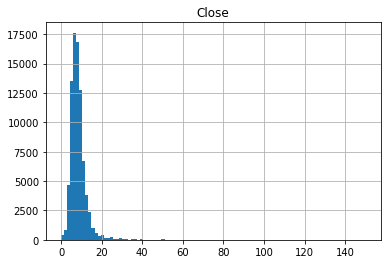

In [41]:
# inverse only for Close (Target)
y_log_inversed = inverse_trans_yeo_johnson(all_data_lagged2["Close"].values.reshape(-1,1), all_data_log["Close"].values.reshape(-1, 1))
y_log_inversed = pd.DataFrame(y_log_inversed)
y_log_inversed.columns = ["Close"]
y_log_inversed.hist(bins=100);

OK!! 検証終了！ 上記コードを活用して予測後の価格を逆対数変換して戦略立案に活用

# EDA (for all_data)

## Check the Correlation between features
    -->相関が極めて高いものはグルーピングして訓練データ内でダブらないようにする


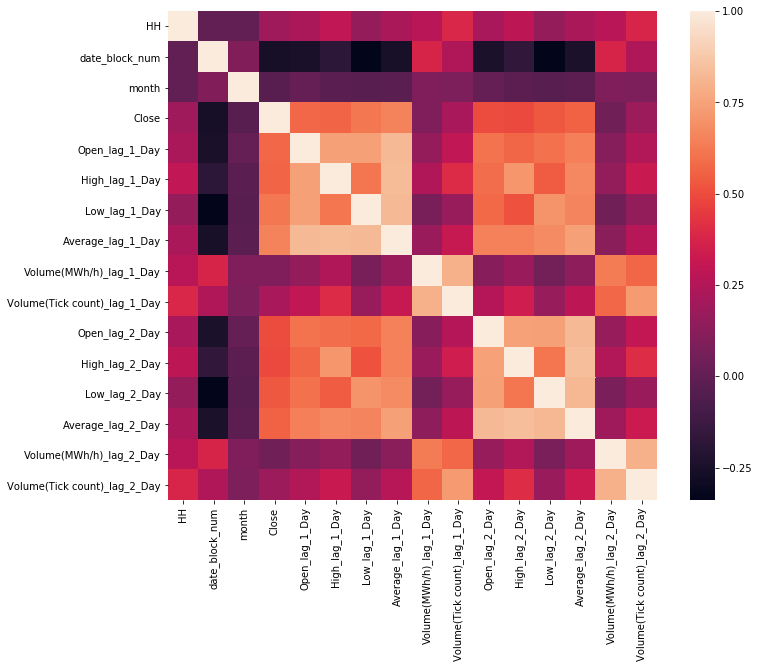

In [42]:
# correlation matrix
corrmat = all_data_log.corr()
f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, square=True);

## Check the correlation of features with the target
    -->上位相関(正と負)はピックアップして更に数値にしてみる

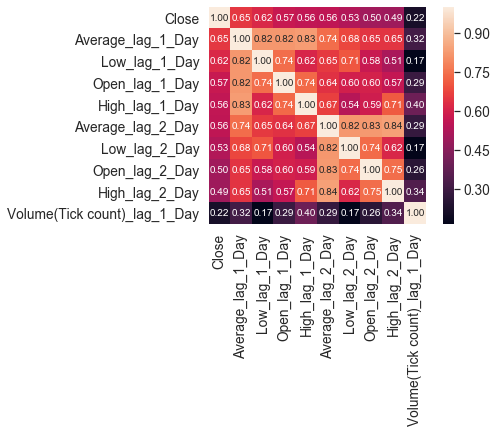

In [43]:
# revenue correlation matrix
k = 10 # The number of variables on the heatmap
cols = corrmat.nlargest(k, 'Close')['Close'].index
cm = np.corrcoef(all_data_log[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

※ちなみにDay1_lagの場合、Ave=0.65, Low=0.62, Open=0.57, Low_HHlag=0.57,HIgh=0.56,Ave_HHlag=0.55<p>
(Day2の場合、相関が結構下がるため、改善の余地あり)

In [ ]:
# # scatterplot
# sns.set()
# cols = ['Close', 'Average_lag_1_Day', 'Average_lag_49_HH', 'Low_lag_1_Day', 'Low_lag_49_HH', 
#         'Open_lag_1_Day', 'Open_lag_49_HH', 'High_lag_1_Day', 'High_lag_49_HH', 'Average_lag_2_Day']
# sns.pairplot(all_data_log[cols], size=2.5)
# plt.show()

<メモ><p>
    - 外れ値は見られるが線形の関係が見られる
    - OpenとCloseの相関は見られないが、OpenとHighはなぜか相関が高い。（Openで高値がつきやすい？）
    - TokyoとTohokuは高い相関が見られる

外れ値はここで処理しておく --> ただし一概に外れ値を除去するべきとは限らない。要検討 <P>
全体のEDAで気になる点がでれば個別にEDA

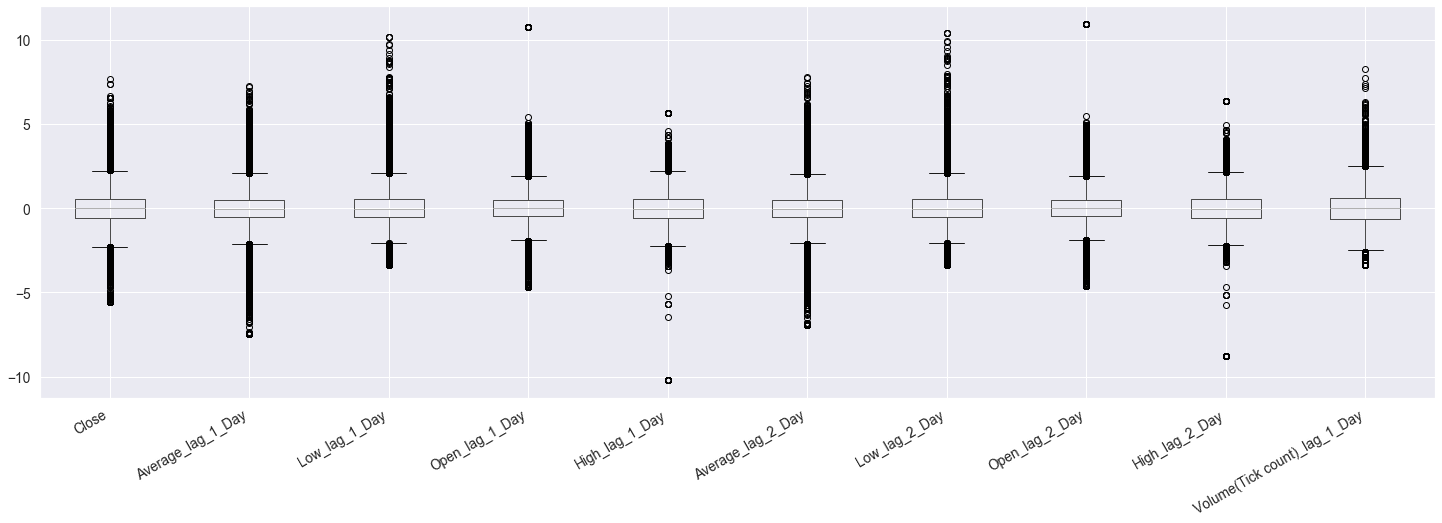

In [45]:
plt.figure(figsize = (25,8))
all_data_log[cols].boxplot()
plt.gcf().autofmt_xdate()

plt.show()

スケールも整っている

# Training Models with "all_data"

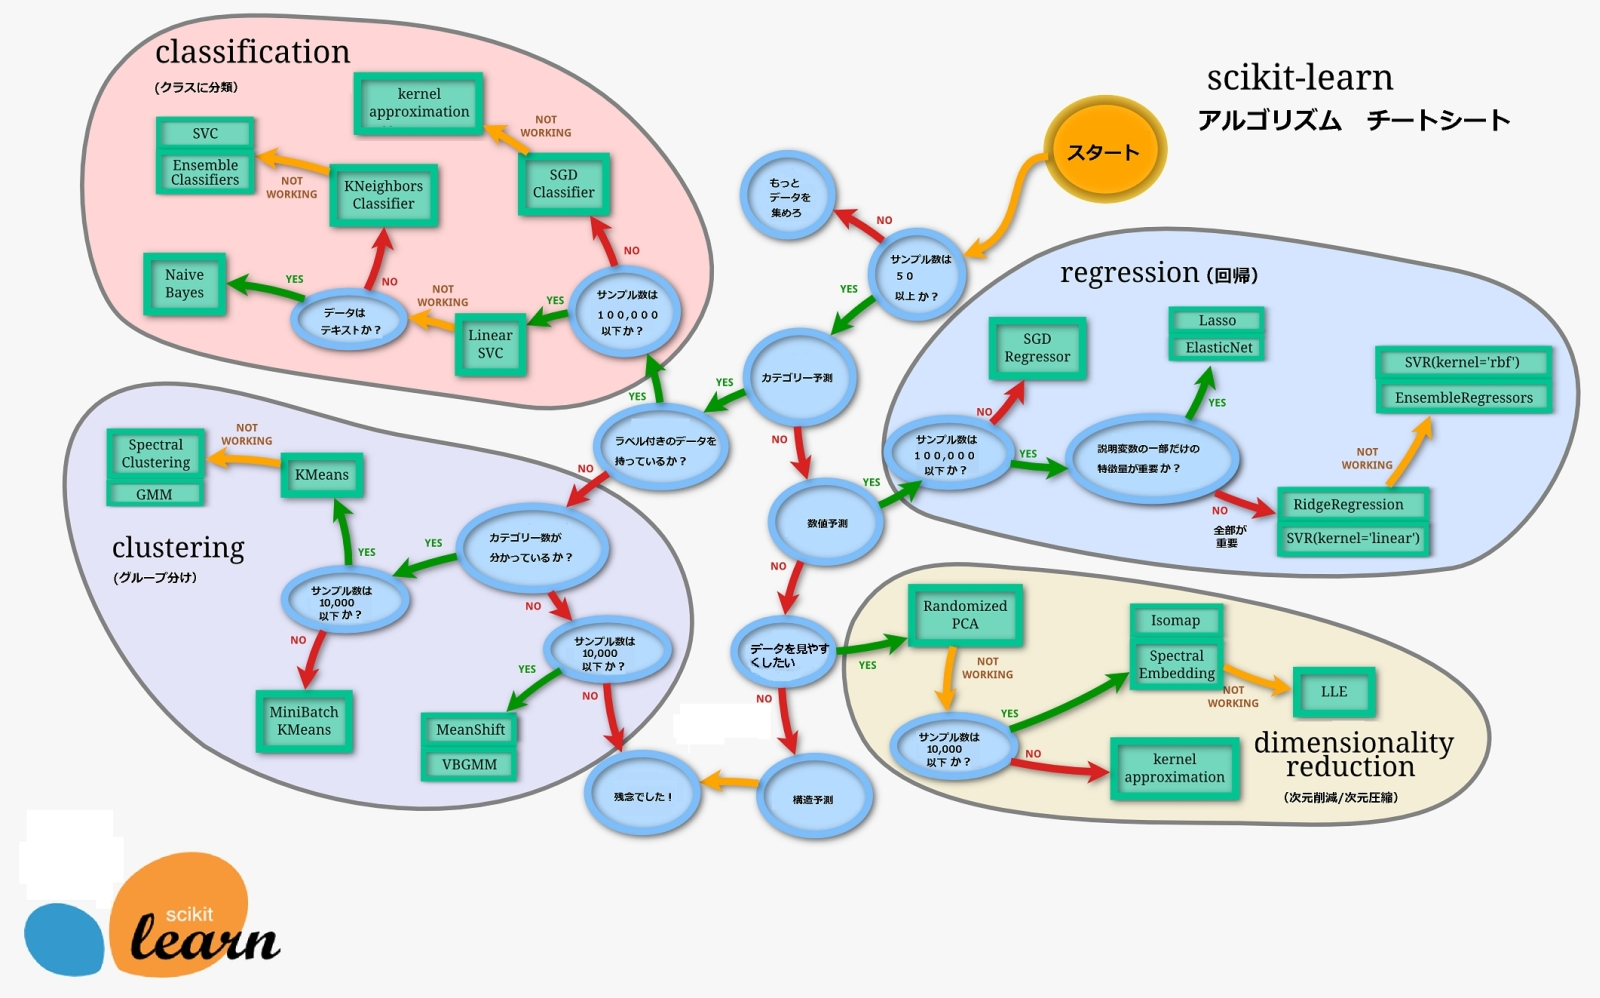

Source: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

SDG Regressor, Lassoあたりが気になるところ。。。

ここですべきことはクロスバリデーションでのモデル構築

TimeSeries validation from scikit-learn
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

参照(ブログ)
https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4

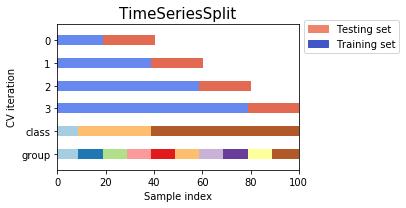

Split all_data set based on time-base

※SckitlearnのTimeseriesSplitでmax_train_sizeを指定できる！！

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

## Preparation

In [46]:
X = all_data_log.drop(['Close', 'Date', 'Time'], axis=1)
y = all_data_log.Close

In [ ]:
# # Time series validation　※今回は使わない
# from sklearn.model_selection import TimeSeriesSplit

# n_splits=10
# test_size=1680 # about 20% of the sample size devided by 10

# tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)
# Min_valid_index = max(X.index) - n_splits * test_size + 1

# print(tscv)
# print('Minimum of valid_index: %.0f' % Min_valid_index)

# # Confirming the split logic
# for train_index, valid_index in tscv.split(X):
#     # Divide the train/valid set  into 10 folds and pick up it.
#     X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
#     y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
#     print("TRAIN:", train_index, "Valid:", valid_index)

(Reference)

- Out_of_Sample_test(Rolling origin): file:///Users/kenotsu/Downloads/OutofSampleTests2000.pdf

In [47]:
# Rolling origin/Walk forward validation
all_records = len(X) # The number of row of train data, including "0"
n_splits = 10
valid_size =1680  # about 20% of the sample size devided by 10
Initial_train = all_records - valid_size*n_splits # the number of the last index of train data

# for t, v in zip
Rolling_forward_split_train = list(range(Initial_train, all_records, valid_size))
Rolling_forward_split_valid = list(range(Initial_train+valid_size, all_records+valid_size,  valid_size))

Min_valid_index = all_records -  n_splits * valid_size
print('Minimum of valid_index: %.0f' % Min_valid_index)

# Confirming the logic for validation split
for train_index, valid_index in zip(Rolling_forward_split_train, Rolling_forward_split_valid):
    # Divide the train/valid set  into 10 folds and pick up it.
    X_train, X_valid = X.iloc[:train_index], X.iloc[train_index: valid_index]
    y_train, y_valid = y.iloc[:train_index], y.iloc[train_index: valid_index]
    print("TRAIN:", X_train.index[-1], "Valid:", X_valid.index[-1])

Minimum of valid_index: 66528
TRAIN: 66527 Valid: 68207
TRAIN: 68207 Valid: 69887
TRAIN: 69887 Valid: 71567
TRAIN: 71567 Valid: 73247
TRAIN: 73247 Valid: 74927
TRAIN: 74927 Valid: 76607
TRAIN: 76607 Valid: 78287
TRAIN: 78287 Valid: 79967
TRAIN: 79967 Valid: 81647
TRAIN: 81647 Valid: 83327


Make the tables for graph visualisation and for evaluation results

In [48]:
# DataTable for graph_log
graph_data_log = all_data_log[["Date", "Time", "Close"]]
graph_data_log["DateTime"] = pd.to_datetime(graph_data_log["Date"].astype(str) + " " + graph_data_log["Time"].astype(str))
prediction_point = graph_data_log["DateTime"][graph_data_log.index==Min_valid_index].iat[-1]
graph_data_log = graph_data_log.drop(["Date", "Time"], axis=1)
print("Prediction_point: {}".format(prediction_point))

# DataTable for Evaluation results_log
Eval_table_log = pd.DataFrame()
Eval_table_log["EvalFunc"] = pd.Series(["RMSE_log", "MAE_log"])
Eval_table_log

Prediction_point: 2020-01-17 00:00:00


,EvalFunc
0,RMSE_log
1,MAE_log


In [49]:
# DataTable for graph_original
graph_data_original = all_data_lagged[["Date", "Time", "Close"]]
graph_data_original["DateTime"] = pd.to_datetime(graph_data_original["Date"].astype(str) + " " + graph_data_original["Time"].astype(str))
prediction_point = graph_data_original["DateTime"][graph_data_original.index==Min_valid_index].iat[-1]
graph_data_original = graph_data_original.drop(["Date", "Time"], axis=1)
print("Prediction_point: {}".format(prediction_point))

# DataTable for Evaluation functions_original
Eval_table_original = pd.DataFrame()
Eval_table_original["EvalFunc"] = pd.Series(["RMSE_Yen/kWh", "MAE_Yen/kWh"])
Eval_table_original

Prediction_point: 2020-01-17 00:00:00


,EvalFunc
0,RMSE_Yen/kWh
1,MAE_Yen/kWh


## Linear model

LassoとRidgeは以下を参照
https://hira03.hatenablog.com/entry/LinearRegression_Ridge_Lasso#LinearRegression%E3%81%A7%E5%AD%A6%E7%BF%92%E3%83%A2%E3%83%87%E3%83%AB%E3%82%92%E7%94%9F%E6%88%90%E3%81%99%E3%82%8B

### Linear regression

In [50]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from numpy import sqrt
import itertools

training_accuracy = []
valid_accuracy = []
rmse = []
mae = []
prediction_Line = []

for train_index, valid_index in zip(Rolling_forward_split_train, Rolling_forward_split_valid):
    # Divide the train/valid set  into 10 folds and pick up it.
    X_train, X_valid = X.iloc[:train_index], X.iloc[train_index: valid_index]
    y_train, y_valid = y.iloc[:train_index], y.iloc[train_index: valid_index]
    
    #Fit train set to the model (Chooose one model)
    modelLine = LinearRegression().fit(X_train, y_train)

    # Generate prediction results
    y_pred = modelLine.predict(X_valid)
    true_values = y_valid.values
    # Save prediction results
    prediction_Line.append(y_pred)
    # Save evaluation results for each 10 validation and get mean
    training_accuracy.append(modelLine.score(X_train, y_train))     
    valid_accuracy.append(modelLine.score(X_valid, y_valid))     
    rmse.append(sqrt(mean_squared_error(true_values, y_pred)))       
    mae.append(mean_absolute_error(true_values, y_pred))

# print("Training_accuracy: {}".format(training_accuracy))
print("Training_accuracy: {}".format(np.mean(training_accuracy)))
# print("Valid_accuracy: {}".format(valid_accuracy))
print("Valid_accuracy: {}".format(np.mean(valid_accuracy)))

# print("RMSE: {}".format(rmse))
print("RMSE: {}".format(np.mean(rmse)))
# print("MAE: {}".format(mae))
print("MAE: {}".format(np.mean(mae)))

# Convert prediction results with valid data from 2D list to 1D list
prediction_Line = list(itertools.chain.from_iterable(prediction_Line))
# Prediction with train data
y_pred_train = list(modelLine.predict(X_train)[:Min_valid_index])
# Store the prediction into the "graph data" table
graph_data_log["Close_pred_Linear"] = pd.Series(y_pred_train + prediction_Line)
# Store the result of evaluation into the "Eval_table"
Eval_table_log["Linear"] = pd.Series([np.mean(rmse), np.mean(mae)])

Training_accuracy: 0.4192981532921955
Valid_accuracy: 0.18535824195878017
RMSE: 0.9325930338507549
MAE: 0.6453281276930207


### Ridge

In [ ]:
# Searching the optimal alpha
for train_index, valid_index in zip(Rolling_forward_split_train, Rolling_forward_split_valid):
    # Divide the train/valid set  into 10 folds and pick up it.
    X_train, X_valid = X.iloc[:train_index], X.iloc[train_index: valid_index]
    y_train, y_valid = y.iloc[:train_index], y.iloc[train_index: valid_index]
    
    # For the test of alpha
    for alpha in [0.1, 1, 3, 7, 10]: # alphaで特に結果の違いなし (0.1, 1, 3, 7, 10)
        modelRidge = Ridge(alpha=alpha).fit(X_train, y_train)
        print("\n alpha={}".format(str(alpha)))
        print("Train set score: {:.2f}".format(modelRidge.score(X_train, y_train)))
        print("Test set score: {:.2f}".format(modelRidge.score(X_valid, y_valid)))
        y_pred = modelRidge.predict(X_valid)       
        print("RMSE: {:.2f}".format(sqrt(mean_squared_error(y_valid, y_pred))) )      
        print("MAE: {:.2f}".format(mean_absolute_error(y_valid, y_pred)))
        print("Number of features used:{}".format(np.sum(modelRidge.coef_ != 0)))

All the parameter has the same result. -->Choose "10"

In [51]:
training_accuracy = []
valid_accuracy = []
rmse = []
mae = []
prediction_Ridge = []

for train_index, valid_index in zip(Rolling_forward_split_train, Rolling_forward_split_valid):
    # Divide the train/valid set  into 10 folds and pick up it.
    X_train, X_valid = X.iloc[:train_index], X.iloc[train_index: valid_index]
    y_train, y_valid = y.iloc[:train_index], y.iloc[train_index: valid_index]
    
    #Fit train set to the model
    modelRidge = linear_model.Ridge(alpha=10).fit(X_train, y_train)

    # Generate prediction results
    y_pred = modelRidge.predict(X_valid)
    true_values = y_valid.values
    # Save prediction results
    prediction_Ridge.append(y_pred)
    # Save evaluation results for each 10 validation and get mean
    training_accuracy.append(modelRidge.score(X_train, y_train))     
    valid_accuracy.append(modelRidge.score(X_valid, y_valid))     
    rmse.append(sqrt(mean_squared_error(true_values, y_pred)))       
    mae.append(mean_absolute_error(true_values, y_pred))

# print("Training_accuracy: {}".format(training_accuracy))
print("Training_accuracy: {}".format(np.mean(training_accuracy)))
# print("Valid_accuracy: {}".format(valid_accuracy))
print("Valid_accuracy: {}".format(np.mean(valid_accuracy)))

# print("RMSE: {}".format(rmse))
print("RMSE: {}".format(np.mean(rmse)))
# print("MAE: {}".format(mae))
print("MAE: {}".format(np.mean(mae)))

# Convert prediction results with valid data from 2D list to 1D list
prediction_Ridge = list(itertools.chain.from_iterable(prediction_Ridge))
# Prediction with train data
y_pred_train = list(modelRidge.predict(X_train)[:Min_valid_index])
# Store the prediction into the "graph data" table
graph_data_log["Close_pred_Ridge"] = pd.Series(y_pred_train + prediction_Ridge)
# Store the result of evaluation into the "Eval_table"
Eval_table_log["Ridge"] = pd.Series([np.mean(rmse), np.mean(mae)])

Training_accuracy: 0.4192981446187639
Valid_accuracy: 0.18535857797296873
RMSE: 0.9325940267022949
MAE: 0.6453277155871119


### Lasso

In [ ]:
for train_index, valid_index in zip(Rolling_forward_split_train, Rolling_forward_split_valid):
    # Divide the train/valid set  into 10 folds and pick up it.
    X_train, X_valid = X.iloc[:train_index], X.iloc[train_index: valid_index]
    y_train, y_valid = y.iloc[:train_index], y.iloc[train_index: valid_index]
    
    # For the test of alpha
    for alpha in [0.02, 0.5, 1]: #0.02 is the best (0.02, 0.5, 1)
        modelLasso = Lasso(alpha=alpha).fit(X_train, y_train)
        print("\n alpha={}".format(str(alpha)))
        print("Train set score: {:.2f}".format(modelLasso.score(X_train, y_train)))
        print("Test set score: {:.2f}".format(modelLasso.score(X_valid, y_valid)))
        y_pred = modelLasso.predict(X_valid)       
        print("RMSE: {:.2f}".format(sqrt(mean_squared_error(y_valid, y_pred))) )      
        print("MAE: {:.2f}".format(mean_absolute_error(y_valid, y_pred)))
        print("Number of features used:{}".format(np.sum(modelLasso.coef_ != 0)))

0.02 is the optimal

In [52]:
training_accuracy = []
valid_accuracy = []
rmse = []
mae = []
prediction_Lasso = []

for train_index, valid_index in zip(Rolling_forward_split_train, Rolling_forward_split_valid):
    # Divide the train/valid set  into 10 folds and pick up it.
    X_train, X_valid = X.iloc[:train_index], X.iloc[train_index: valid_index]
    y_train, y_valid = y.iloc[:train_index], y.iloc[train_index: valid_index]
    
    #Fit train set to the model (Chooose one model)
    modelLasso = linear_model.Lasso(alpha=0.02).fit(X_train, y_train)

    # Generate prediction results
    y_pred = modelLasso.predict(X_valid)
    true_values = y_valid.values
    # Save prediction results
    prediction_Lasso.append(y_pred)
    # Save evaluation results for each 10 validation and get mean
    training_accuracy.append(modelLasso.score(X_train, y_train))     
    valid_accuracy.append(modelLasso.score(X_valid, y_valid))     
    rmse.append(sqrt(mean_squared_error(true_values, y_pred)))       
    mae.append(mean_absolute_error(true_values, y_pred))

# print("Training_accuracy: {}".format(training_accuracy))
print("Training_accuracy: {}".format(np.mean(training_accuracy)))
# print("Valid_accuracy: {}".format(valid_accuracy))
print("Valid_accuracy: {}".format(np.mean(valid_accuracy)))

# print("RMSE: {}".format(rmse))
print("RMSE: {}".format(np.mean(rmse)))
# print("MAE: {}".format(mae))
print("MAE: {}".format(np.mean(mae)))

# Convert prediction results with valid data from 2D list to 1D list
prediction_Lasso = list(itertools.chain.from_iterable(prediction_Lasso))
# Prediction with train data
y_pred_train = list(modelLasso.predict(X_train)[:Min_valid_index])
# Store the prediction into the "graph data" table
graph_data_log["Close_pred_Lasso"] = pd.Series(y_pred_train + prediction_Lasso)
# Store the result of evaluation into the "Eval_table"
Eval_table_log["Lasso"] = pd.Series([np.mean(rmse), np.mean(mae)])

Training_accuracy: 0.41636185943405113
Valid_accuracy: 0.1652102516609622
RMSE: 0.9442882629408649
MAE: 0.654776776534708


Ridge is a little bit better than others

### Interpretation of the linear model (Only for the best model)
https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html

In [ ]:
print("Intercept: {}".format(modelLine.intercept_))

feature_names = X_train.columns
coefs = pd.DataFrame(modelRidge.coef_, columns=['Coefficients'], index=feature_names
).sort_values('Coefficients', ascending=False)
coefs

In [ ]:
coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Linear model')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

## Non-linear model

### Linear Regression with PolynomialFeatures

In [88]:
X.shape

(83328, 15)

In [87]:
Poly_X.shape

(83328, 136)

In [54]:
from sklearn.preprocessing import PolynomialFeatures

dimension = 2

# 多項式をつくる
polynomial = PolynomialFeatures(degree=dimension)
Poly_X = polynomial.fit_transform(X)
Poly_X = pd.DataFrame(Poly_X)

training_accuracy = []
valid_accuracy = []
rmse = []
mae = []
prediction_PolyLine = []
    
for train_index, valid_index in zip(Rolling_forward_split_train, Rolling_forward_split_valid):
    # Divide the train/valid set  into 10 folds and pick up it.
    X_train, X_valid = Poly_X.iloc[:train_index], Poly_X.iloc[train_index: valid_index]
    y_train, y_valid = y.iloc[:train_index], y.iloc[train_index: valid_index]
    
    #Fit train set to the model (Chooose one model)
    modelPolyLine = LinearRegression().fit(X_train, y_train)
    
    # Generate prediction results
    y_pred = modelPolyLine.predict(X_valid)
    true_values = y_valid.values
    # Save prediction results
    prediction_PolyLine.append(y_pred)
    # Save evaluation results for each 10 validation and get mean
    training_accuracy.append(modelPolyLine.score(X_train, y_train))     
    valid_accuracy.append(modelPolyLine.score(X_valid, y_valid))     
    rmse.append(sqrt(mean_squared_error(true_values, y_pred)))       
    mae.append(mean_absolute_error(true_values, y_pred))

# print("Training_accuracy: {}".format(training_accuracy))
print("Training_accuracy: {}".format(np.mean(training_accuracy)))
# print("Valid_accuracy: {}".format(valid_accuracy))
print("Valid_accuracy: {}".format(np.mean(valid_accuracy)))

# print("RMSE: {}".format(rmse))
print("RMSE: {}".format(np.mean(rmse)))
# print("MAE: {}".format(mae))
print("MAE: {}".format(np.mean(mae)))

# Convert prediction results with valid data from 2D list to 1D list
prediction_PolyLine = list(itertools.chain.from_iterable(prediction_PolyLine))
# Prediction with train data
y_pred_train = list(modelPolyLine.predict(X_train)[:Min_valid_index])
# Store the prediction into the "graph data" table
#graph_data_log = graph_data_log.reset_index()
graph_data_log["Close_pred_PolyLinear"] = pd.Series(y_pred_train + prediction_PolyLine)
# Store the result of evaluation into the "Eval_table"
Eval_table_log["PolyLinear"] = pd.Series([np.mean(rmse), np.mean(mae)])

Training_accuracy: 0.46146799287430273
Valid_accuracy: 0.2153195329233386
RMSE: 0.922516975649717
MAE: 0.6281417191486753


### XGBoost

In [55]:
from xgboost import XGBRegressor

training_accuracy = []
valid_accuracy = []
rmse = []
mae = []
prediction_XGB = []

for train_index, valid_index in zip(Rolling_forward_split_train, Rolling_forward_split_valid):
    # Divide the train/valid set  into 10 folds and pick up it.
    X_train, X_valid = X.iloc[:train_index], X.iloc[train_index: valid_index]
    y_train, y_valid = y.iloc[:train_index], y.iloc[train_index: valid_index]

    #Fit train set to the model
    modelXGB = XGBRegressor().fit(X_train, y_train)   
    # Generate prediction results
    y_pred = modelXGB.predict(X_valid)
    true_values = y_valid.values
    # Save prediction results
    prediction_XGB.append(y_pred)
    # Save evaluation results for each 10 validation and get mean
    training_accuracy.append(modelXGB.score(X_train, y_train))     
    valid_accuracy.append(modelXGB.score(X_valid, y_valid))     
    rmse.append(sqrt(mean_squared_error(true_values, y_pred)))       
    mae.append(mean_absolute_error(true_values, y_pred))

# print("Training_accuracy: {}".format(training_accuracy))
print("Training_accuracy: {}".format(np.mean(training_accuracy)))
# print("Valid_accuracy: {}".format(valid_accuracy))
print("Valid_accuracy: {}".format(np.mean(valid_accuracy)))

# print("RMSE: {}".format(rmse))
print("RMSE: {}".format(np.mean(rmse)))
# print("MAE: {}".format(mae))
print("MAE: {}".format(np.mean(mae)))

# Convert prediction results with valid data from 2D list to 1D list
prediction_XGB = list(itertools.chain.from_iterable(prediction_XGB))
# Prediction with train data
y_pred_train = list(modelXGB.predict(X_train)[:Min_valid_index])
# Store the prediction into the "graph data" table
graph_data_log["Close_pred_XGB"] = pd.Series(y_pred_train + prediction_XGB)
# Store the result of evaluation into the "Eval_table"
Eval_table_log["XGB"] = pd.Series([np.mean(rmse), np.mean(mae)])

Training_accuracy: 0.6995822411428876
Valid_accuracy: -0.02944036054371233
RMSE: 1.0709693345122846
MAE: 0.7593400804324304


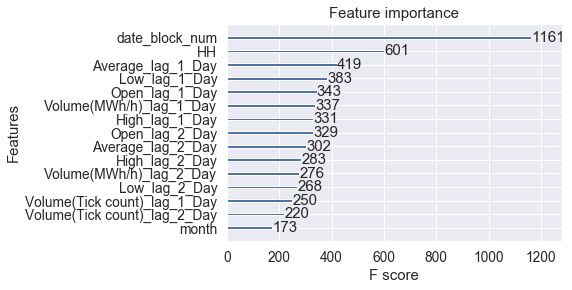

<Figure size 1000x500 with 0 Axes>

In [56]:
from xgboost import plot_importance

# plot feature importance
plot_importance(modelXGB, max_num_features = 20)
plt.figure(figsize=(10, 5),dpi=100)
plt.show()

日にちや時間が上位に。。。あってるのか？？

### RamdomForest※時間がかかるので注意

In [ ]:
# from sklearn.ensemble import RandomForestRegressor

# training_accuracy = []
# valid_accuracy = []
# rmse = []
# mae = []
# prediction_RF = []

# for train_index, valid_index in zip(Rolling_forward_split_train, Rolling_forward_split_valid):
#     # Divide the train/valid set  into 10 folds and pick up it.
#     X_train, X_valid = X.iloc[:train_index], X.iloc[train_index: valid_index]
#     y_train, y_valid = y.iloc[:train_index], y.iloc[train_index: valid_index]

#     #Fit train set to the model
#     modelRF = RandomForestRegressor(n_jobs = -1).fit(X_train, y_train) 
#     # Generate prediction results
#     y_pred = modelRF.predict(X_valid)
#     true_values = y_valid.values
#     # Save prediction results
#     prediction_RF.append(y_pred)
#     # Save evaluation results for each 10 validation and get mean
#     training_accuracy.append(modelRF.score(X_train, y_train))     
#     valid_accuracy.append(modelRF.score(X_valid, y_valid))     
#     rmse.append(sqrt(mean_squared_error(true_values, y_pred)))       
#     mae.append(mean_absolute_error(true_values, y_pred))

# # print("Training_accuracy: {}".format(training_accuracy))
# print("Training_accuracy: {}".format(np.mean(training_accuracy)))
# # print("Valid_accuracy: {}".format(valid_accuracy))
# print("Valid_accuracy: {}".format(np.mean(valid_accuracy)))

# # print("RMSE: {}".format(rmse))
# print("RMSE: {}".format(np.mean(rmse)))
# # print("MAE: {}".format(mae))
# print("MAE: {}".format(np.mean(mae)))

# # Convert prediction results with valid data from 2D list to 1D list
# prediction_RF = list(itertools.chain.from_iterable(prediction_RF))
# # Prediction with train data
# y_pred_train = list(modelRF.predict(X_train)[:Min_valid_index])
# # Store the prediction into the "graph data" table
# graph_data_log["Close_pred_RF"] = pd.Series(y_pred_train + prediction_RF)
# # Store the result of evaluation into the "Eval_table"
# Eval_table_log["RF"] = pd.Series([np.mean(rmse), np.mean(mae)])

In [ ]:
# # Random Forestのfeature importance作成
# # plot feature importance
# df_feature_importance = pd.DataFrame(modelRF.feature_importances_, index=feature_list, columns=['feature importance']).sort_values('feature importance', ascending=True)
# #df_feature_all = pd.DataFrame([tree.feature_importances_ for tree in reg.estimators_], columns=boston.feature_names)
# df_feature_importance_top10 = df_feature_importance.tail(10)
# df_feature_importance_top10.plot(kind='barh');

## Statistical model (基本的にパラメータチューニングはしない！)
- 時系列モデル推定のための用語解説 https://qiita.com/tatsuya11bbs/items/daed7e7bca46a6892585

- 対数化していないターゲットを使用する (自己回帰のためその他の説明変数は不要) <p>
 -->現時点では対数化されたターゲットをfitさせているが、これがエラーの原因かもしれない...

- 季節性だけは確認しておかないといけない --> 今回は48 (１日おき)
- 季節性を考慮するならSARIMAモデルを使用する

In [57]:
# Data for statistical modeling
y_stats = all_data_log[["Date", "Time", "Close"]]
y_stats["DateTime"] = pd.to_datetime(y_stats["Date"].astype(str) + " " + y_stats["Time"].astype(str))
y_stats = y_stats.drop(["Date", "Time"], axis=1)

In [58]:
# ADF test for logarithmic price
ctt = sm.tsa.adfuller(y_stats.Close, regression="ctt")
round(ctt[1], 4)

0.0

Null hypothesis on ADF test could be rejected, so logarithmic price can be used for modeling.

### ARIMA

(reference) <p>

- わかりやすい： https://logics-of-blue.com/python-time-series-analysis/ <p>
    -->別紙(パラメータ): https://logics-of-blue.com/wp-content/uploads/2017/05/python-time-series-analysis-notebook.html#ARIMA%E3%83%A2%E3%83%87%E3%83%AB%E3%81%AE%E6%8E%A8%E5%AE%9A
    
- かなり細かい: https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/

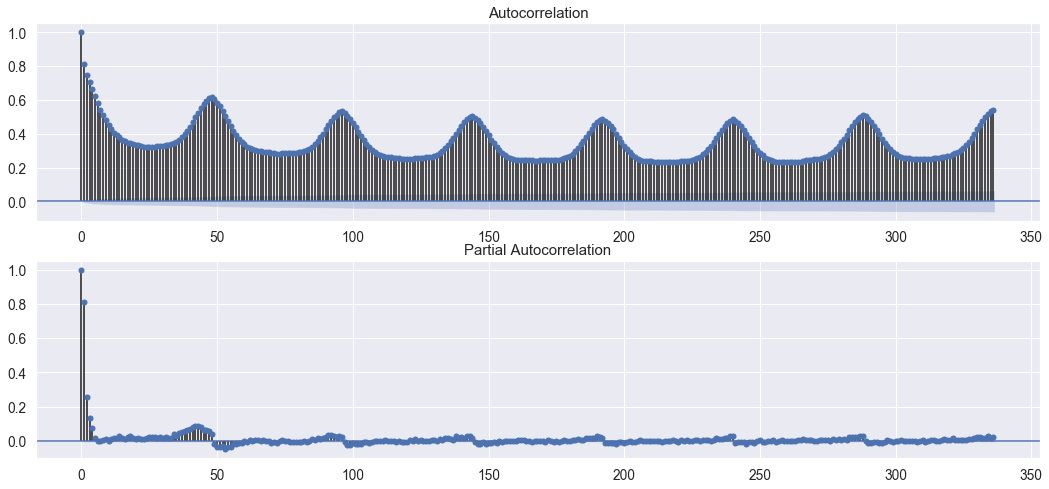

In [59]:
# Autocorrelation
fig = plt.figure(figsize=(18,8))
# Autocorrelation (1lag=30min --> 336 lags=1week)
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(y_stats.Close, lags=336, ax=ax1)

# Partial Autocorrelation
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(y_stats.Close, lags=336, ax=ax2)

In [60]:
# # Searching the optimal parameters for ARIMA
# resDiff = sm.tsa.arma_order_select_ic(y_stats.Close, ic='aic', trend='nc')
# resDiff

In [61]:
from statsmodels.tsa.arima.model import ARIMA

modelARIMA = ARIMA(y_stats.Close).fit()

# Summary
print(modelARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                83328
Model:                          ARIMA   Log Likelihood             -118237.310
Date:                Sat, 20 Mar 2021   AIC                         236478.620
Time:                        21:05:10   BIC                         236497.281
Sample:                             0   HQIC                        236484.330
                              - 83328                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.911e-06      0.003     -0.001      0.999      -0.007       0.007
sigma2         1.0000      0.003    384.360      0.000       0.995       1.005
Ljung-Box (L1) (Q):               55067.88   Jarque-

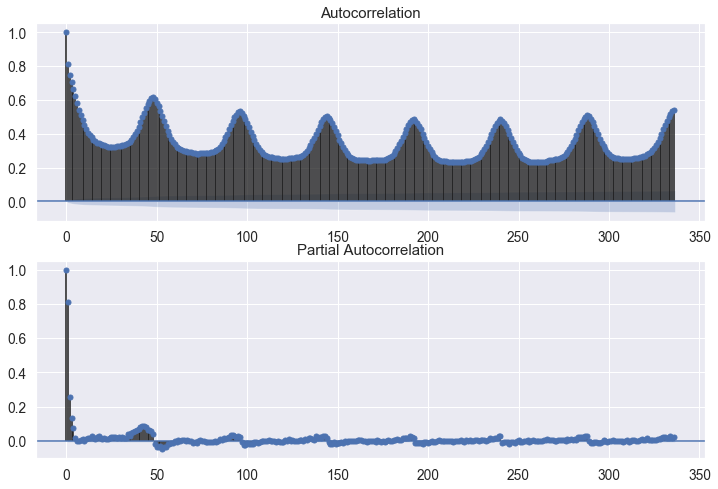

In [62]:
# Check the residual
resid = modelARIMA.resid
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid.values.squeeze(), lags=336, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=336, ax=ax2)

残差に周期性やパターンが残っているということは、モデルにそれらを組み込めていないということ

In [63]:
training_accuracy = []
valid_accuracy = []
rmse = []
mae = []
prediction_ARIMA = []

# Set the parameter for .predict() which is for in-sample prediciton
train_end =  prediction_point.to_pydatetime() - datetime.timedelta(minutes=30)

for train_index, valid_index in zip(Rolling_forward_split_train, Rolling_forward_split_valid):
    # Divide the train/valid set  into 10 folds and pick up it.
    y_train, y_valid = y_stats.iloc[:train_index], y_stats.iloc[train_index: valid_index]
    y_train, y_valid = y_train.set_index("DateTime"), y_valid.set_index("DateTime")
 
    #Fit train set to the model
    modelARIMA = ARIMA(y_train, 
#                        order=(2, 0, 3),
                      ).fit() #上記セルのパラメータを参照
    # Generate prediction results
    y_pred = modelARIMA.forecast(steps=valid_size) # valid_size is set on "Preparation"
    true_values = y_valid.values
    # Save prediction results
    prediction_ARIMA.append(y_pred)
    # Save evaluation results for each 10 validation and get mean
    rmse.append(sqrt(mean_squared_error(true_values, y_pred)))       
    mae.append(mean_absolute_error(true_values, y_pred))

# print("RMSE: {}".format(rmse))
print("RMSE: {}".format(np.mean(rmse)))
# print("MAE: {}".format(mae))
print("MAE: {}".format(np.mean(mae)))

# Convert prediction results with valid data from 2D list to 1D list
prediction_ARIMA = list(itertools.chain.from_iterable(prediction_ARIMA))
# Prediction with train data
y_pred_train = list(modelARIMA.predict(end=train_end))
# Store the prediction into the "graph data" table
graph_data_log = graph_data_log.reset_index()
graph_data_log["Close_pred_ARIMA"] = pd.Series(y_pred_train + prediction_ARIMA)
# Store the result of evaluation into the "Eval_table"
Eval_table_log["ARIMA"] = pd.Series([np.mean(rmse), np.mean(mae)])

RMSE: 1.4495983990613452
MAE: 1.1459508559713072


### SARIMAX

In [64]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

modelSARIMA = SARIMAX(y_stats.Close).fit()
print(modelSARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                83328
Model:               SARIMAX(1, 0, 0)   Log Likelihood              -73179.456
Date:                Sat, 20 Mar 2021   AIC                         146362.912
Time:                        21:07:09   BIC                         146381.573
Sample:                             0   HQIC                        146368.622
                              - 83328                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8130      0.001    738.925      0.000       0.811       0.815
sigma2         0.3391      0.001    508.496      0.000       0.338       0.340
Ljung-Box (L1) (Q):                3723.21   Jarque-

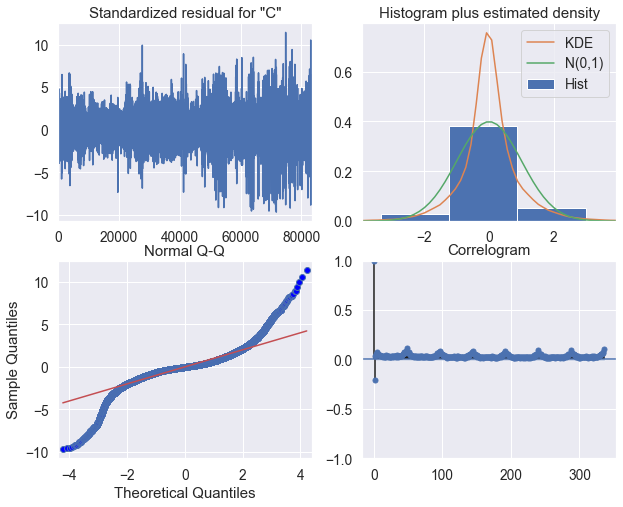

In [65]:
# Check residual (If periodicity can be seen, SARIMA model would be better)
# Plot/confirm residual (White noise)
modelSARIMA.plot_diagnostics(lags=336, figsize=[10, 8]);

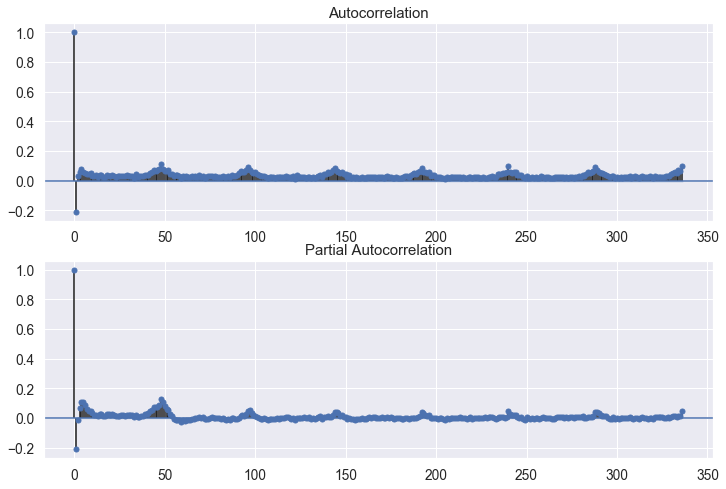

In [66]:
# Plot pertial Autocorrelation
resid = modelSARIMA.resid
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid.values.squeeze(), lags=336, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=336, ax=ax2)

SARIMAモデルのほうが季節性をカバーできているみたい --> SARIMAXですすめる

In [67]:
# y_train = y.iloc[Min_valid_index:]
# res = sm.tsa.arma_order_select_ic(y_train, max_ar=5, max_ma=7, ic='aic')
# print(res.aic_min_order)

(引用) https://ai-trend.jp/basic-study/time-series-analysis/sarima_model/　より <p>
赤池情報量基準 (Akaike Information Criterion: AIC)

尤度とは、モデルの尤（もっと）もらしさのことです。 あるパラメータを持つモデルにデータが従うと仮定したとき、そのデータが得られる確率はそのパラメータの関数となり、これを尤度 (Likelihood) といいます。 尤度の対数を最大にするようにパラメータを推定する方法は最尤推定とよばれ、その時の尤度を最大対数尤度といいます。 用いるパラメータを増やせば増やすほど、つまりモデルが複雑であればあるほど、基本的に当てはまりは良くなります。 一方で、パラメータが多いほどデータに過剰に適合してしまい、未知のデータに対する精度が悪くなる過学習が起こってしまいます。 AICは次式で定義され、モデルを複雑にすること（パラメータを増やすこと）にペナルティがかかっています。

符号より、AICは小さければ小さいほど良い指標です。 よって、様々な (p,d,q,P,D,Q,s) でSARIMAモデルを最尤推定し、AICが最も小さくなるようなモデルを選択する方針が考えられます。ただし、AICは最大対数尤度に基づいているため、データセットが同じならば異なるモデルを比較することができますが、データが異なる場合は比較できないことに注意してください。

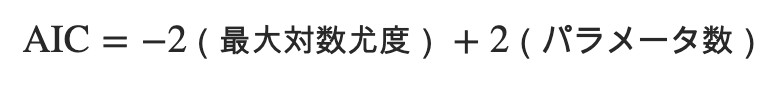

In [68]:
# # 総当たりで、AICが最小となるSARIMAの次数を探す
# max_p = 3
# max_q = 3
# max_d = 2
# max_sp = 1
# max_sq = 1
# max_sd = 1

# pattern = max_p*(max_d + 1)*(max_q + 1)*(max_sp + 1)*(max_sq + 1)*(max_sd + 1)

# modelSelection = pd.DataFrame(index=range(pattern), columns=["model", "aic"])

# # 自動SARIMA選択
# num = 0

# for p in range(1, max_p + 1):
#     for d in range(0, max_d + 1):
#         for q in range(0, max_q + 1):
#             for sp in range(0, max_sp + 1):
#                 for sd in range(0, max_sd + 1):
#                     for sq in range(0, max_sq + 1):
#                         sarima = sm.tsa.SARIMAX(
#                             y_train, order=(p,d,q), 
#                             seasonal_order=(sp,sd,sq,48), 
#                             enforce_stationarity = False, 
#                             enforce_invertibility = False
#                         ).fit()
#                         modelSelection.iloc[num]["model"] = "order=(" + str(p) + ","+ str(d) + ","+ str(q) + "), season=("+ str(sp) + ","+ str(sd) + "," + str(sq) + ")"
#                         modelSelection.iloc[num]["aic"] = sarima.aic
#                         num = num + 1

In [69]:
# # AIC確認
# modelSelection.sort_values(by='aic').head()

上記AICを確認し、AICが最小のパラメータの組み合わせをモデルに適用する

In [70]:
training_accuracy = []
valid_accuracy = []
rmse = []
mae = []
prediction_SARIMA = []

# Set the parameter for .predict() which is for in-sample prediciton
train_end =  prediction_point.to_pydatetime() - datetime.timedelta(minutes=30)

for train_index, valid_index in zip(Rolling_forward_split_train, Rolling_forward_split_valid):
    # Divide the train/valid set  into 10 folds and pick up it.
    y_train, y_valid = y_stats.iloc[:train_index], y_stats.iloc[train_index: valid_index]
    y_train, y_valid = y_train.set_index("DateTime"), y_valid.set_index("DateTime")
 
    #Fit train set to the model
    modelSARIMA = SARIMAX(y_train, 
#                        order=(2, 0, 3),
                      ).fit() #上記セルのパラメータを参照
    # Generate prediction results
    y_pred = modelSARIMA.forecast(steps=valid_size) # valid_size is set on "Preparation"
    true_values = y_valid.values
    # Save prediction results
    prediction_SARIMA.append(y_pred)
    # Save evaluation results for each 10 validation and get mean
    rmse.append(sqrt(mean_squared_error(true_values, y_pred)))       
    mae.append(mean_absolute_error(true_values, y_pred))

# print("RMSE: {}".format(rmse))
print("RMSE: {}".format(np.mean(rmse)))
# print("MAE: {}".format(mae))
print("MAE: {}".format(np.mean(mae)))

# Convert prediction results with valid data from 2D list to 1D list
prediction_SARIMA = list(itertools.chain.from_iterable(prediction_SARIMA))
# Prediction with train data
y_pred_train = list(modelSARIMA.predict(end=train_end))
# Store the prediction into the "graph data" table
graph_data_log = graph_data_log.reset_index()
graph_data_log["Close_pred_SARIMA"] = pd.Series(y_pred_train + prediction_SARIMA)
# Store the result of evaluation into the "Eval_table"
Eval_table_log["SARIMA"] = pd.Series([np.mean(rmse), np.mean(mae)])

RMSE: 1.3955483315331902
MAE: 1.0886929609772489


In-sampleはびっくりするぐらい学習できているが、out-of-sampleは全然ダメ

※In-Sampleのpredictionがしっかり格納されているか確認すること
--> Actualとtrain_predを並べてみる (多少差があればOK)

ARIMAのVisualiseで使えそうなリンク
https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

### State space model (状態空間モデル)

(Reference) <p>
かなり細かい実装方法: https://logics-of-blue.com/python-state-space-models/ <p>
なぜ状態空間モデルを使うのか: https://logics-of-blue.com/%e3%81%aa%e3%81%9c%e7%8a%b6%e6%85%8b%e7%a9%ba%e9%96%93%e3%83%a2%e3%83%87%e3%83%ab%e3%82%92%e4%bd%bf%e3%81%86%e3%81%ae%e3%81%8b/

## Prophet (From Facebook)
Document of Prophet from Facebook
https://peerj.com/preprints/3190/

日本語の解説 (公式ではないが結構細かい)
https://mikiokubo.github.io/analytics/15forecast.html

- Validationについて
-->Time series validationは実装されている <p>
--> Rolling(sliding) origin validationは別途実装する必要がある

Prophet用にデータを加工する <p>
①日時を残す (YYYYMMDD + Time)にする <p>
②列名を変更 (datetime -->dt, target-->y) <p>
③ date_block_num 1736で分割

In [71]:
# Set ds and y for the model
all_data_prop = y_stats.copy()
all_data_prop = all_data_prop.rename(columns={'DateTime': 'ds', 'Close': 'y'})

In [72]:
# Divide dataset into train/valid set
all_data_prop_train = all_data_prop.iloc[all_data_prop.index[:Min_valid_index]]
all_data_prop_valid = all_data_prop.iloc[all_data_prop.index[Min_valid_index:]]

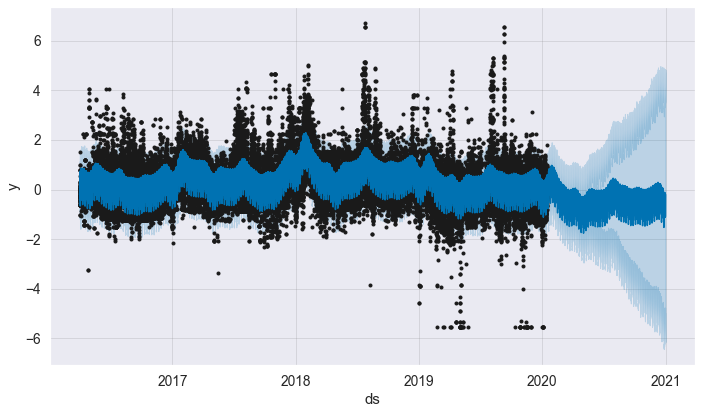

In [73]:
from fbprophet import Prophet

# train dataset for prophet
modelProp = Prophet().fit(all_data_prop_train)

# Make prediction datatable
future = modelProp.make_future_dataframe(periods=len(all_data_prop_valid["y"]), freq='30min')
forecast = modelProp.predict(future)
modelProp.plot(forecast);

[引用:パラメータの解説]
以下の例では、initialが730日なので、729日までの情報を用いて、その後365(horizon)日の予測を行い、本当の値との誤差を評価し、次いで730+180(period)日までの情報を用いて、その後365日の予測を行い評価し、という手順を最後の日まで繰り返す。(2905-730-365)/180 = 10.05であるので、11回の予測を行い評価することになる。cross_validationは、交差検証用のデータフレームを返す。<p>
    -->今回はTraining_dataのデータ日数1736に対し、InInitial1385daysを用いて最初にhorizon35dayを予測し、その後Period35day間隔で予測を繰り返す<p>
    -->つまり(1736-1385-1)/35 = 10times predictions

In [74]:
# from fbprophet.diagnostics import cross_validation
# # ループ文なしでValidatioinしてくれる　--> 学習データは全データ
# modelProp = Prophet().fit(all_data_prop)
# df_cv = cross_validation(modelProp, initial='1385days', period='35days', horizon ='35days')
# df_cv.head()

In [75]:
# from fbprophet.diagnostics import performance_metrics
# df_p = performance_metrics(df_cv, rolling_window=0)
# df_p.head()

In [76]:
# # Save evaluation results for each 10 validation and get mean
# print("RMSE: {}".format(df_p["rmse"].mean()))
# print("MAE: {}".format(df_p["mae"].mean()))

# # Store the prediction into the "graph data" table
# graph_data_log = graph_data_log.reset_index()
# # Merge prediciton with train_data and that are based on cross validation
# pred = pd.concat([forecast.yhat, df_cv.yhat]).reset_index()
# pred = pred.drop("index", axis=1)
# graph_data_log["Close_pred_Prophet"] = pred
# # Store the result of evaluation into the "Eval_table"
# Eval_table_log["Prophet"] = pd.Series([df_p["rmse"].mean(), df_p["mae"].mean()])

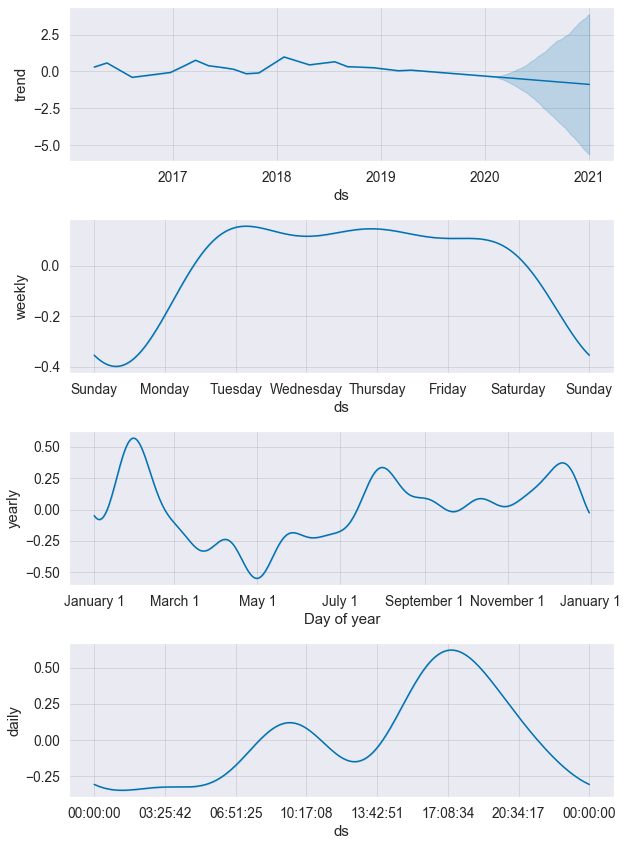

In [77]:
modelProp.plot_components(forecast);

In [78]:
training_accuracy = []
valid_accuracy = []
rmse = []
mae = []
prediction_Prophet = []

# Set the parameter for .predict() which is for in-sample prediciton
train_end =  prediction_point.to_pydatetime() - datetime.timedelta(minutes=30)

for train_index, valid_index in zip(Rolling_forward_split_train, Rolling_forward_split_valid):
    # Divide the train/valid set  into 10 folds and pick up it.
    train_prop, valid_prop = all_data_prop.iloc[:train_index], all_data_prop.iloc[train_index: valid_index]
    y_train, y_valid = train_prop.set_index("ds"), valid_prop.set_index("ds")

    #Fit train set to the model
    modelProphet = Prophet().fit(train_prop)
    # Make prediction datatable
    future = modelProphet.make_future_dataframe(periods=len(valid_prop), freq='30min')
    # Generate prediction results
    forecast = modelProphet.predict(future)
    y_pred = forecast["yhat"][train_index: valid_index]
    true_values = valid_prop["y"]
    # Save prediction results
    prediction_Prophet.append(y_pred)
    # Save evaluation results for each 10 validation and get mean
    rmse.append(sqrt(mean_squared_error(true_values, y_pred)))       
    mae.append(mean_absolute_error(true_values, y_pred))

# print("RMSE: {}".format(rmse))
print("RMSE: {}".format(np.mean(rmse)))
# print("MAE: {}".format(mae))
print("MAE: {}".format(np.mean(mae)))

# Convert prediction results with valid data from 2D list to 1D list
prediction_Prophet = list(itertools.chain.from_iterable(prediction_Prophet))
# Prediction with train data
y_pred_train = list(forecast["yhat"][:Min_valid_index])
# Store the prediction into the "graph data" table
# graph_data_log = graph_data_log.reset_index()
graph_data_log["Close_pred_Prophet"] = pd.Series(y_pred_train + prediction_Prophet)
# Store the result of evaluation into the "Eval_table"
Eval_table_log["Prophet"] = pd.Series([np.mean(rmse), np.mean(mae)])

RMSE: 1.1129639405092315
MAE: 0.7835514285704375


ValueError: cannot insert level_0, already exists

In [81]:
# # Convert prediction results with valid data from 2D list to 1D list
# prediction_Prophet = list(itertools.chain.from_iterable(prediction_Prophet))
# Prediction with train data
y_pred_train = list(forecast["yhat"][:Min_valid_index])
# Store the prediction into the "graph data" table
graph_data_log = graph_data_log.reset_index()
graph_data_log["Close_pred_Prophet"] = pd.Series(y_pred_train + prediction_Prophet)
# Store the result of evaluation into the "Eval_table"
Eval_table_log["Prophet"] = pd.Series([np.mean(rmse), np.mean(mae)])

# Visualisation of the model performance 

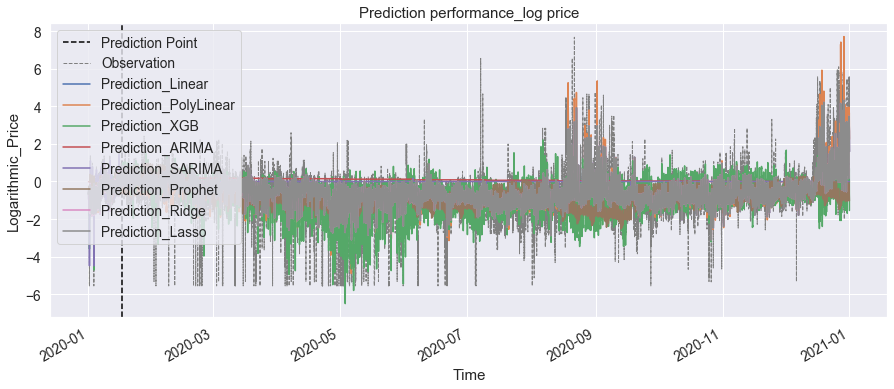

In [83]:
#対数化されたターゲットと予測値の比較

Models = ["Linear", "PolyLinear", "XGB", "ARIMA", "SARIMA", "Prophet", "Ridge", "Lasso"
         ]

start = "2020-01-01 00:00:00"
end = "2020-12-31 23:30:00"

fig, ax = plt.subplots(1, figsize=(15, 6))
plt.title('Prediction performance_log price')

# Set index
graph_data_log = graph_data_log.set_index("DateTime")

# Vertical line (need to convert the date type from timestamp to datetime.datetime as x-axis)
plt.axvline(prediction_point.to_pydatetime(), label="Prediction Point", linestyle="dashed", color="black")

# Plot Close 
graph_data_log.Close[graph_data_log.index > start].plot(ax=ax, label="Observation", linestyle="dashed", color="gray", linewidth=1)

# Plot the predicted price with each model
for model in Models:
    graph_data_log["Close_pred_" + model][graph_data_log.index > start].plot(ax=ax, label="Prediction_" + model)

# x-axis
plt.gcf().autofmt_xdate()
ax.set(xlabel="Time", ylabel="Logarithmic_Price")
plt.legend(loc="upper left");

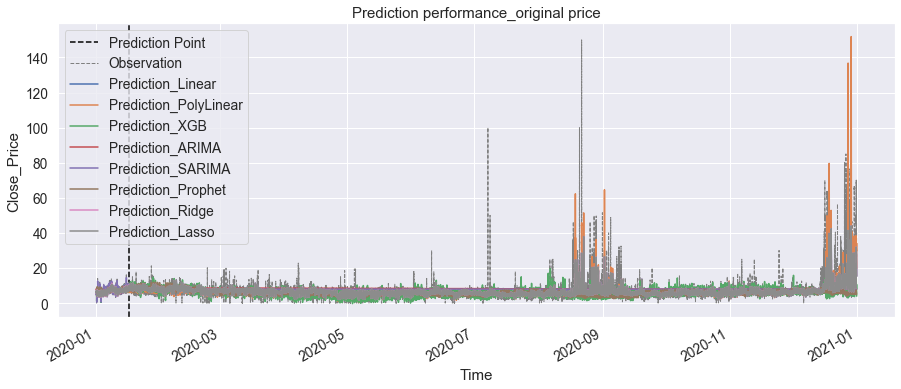

In [84]:
graph_data_original = graph_data_original.reset_index()

Models = ["Linear", "PolyLinear", "XGB", "ARIMA", "SARIMA", "Prophet", "Ridge", "Lasso"]

for model in Models:
    # inverse for Prediction
    y_pred_original = inverse_trans_yeo_johnson(all_data_lagged["Close"].values.reshape(-1,1), graph_data_log["Close_pred_" + model].values.reshape(-1, 1))
    y_pred_original =  pd.DataFrame(y_pred_original)
    # Add the data on "graph_data"
    graph_data_original["Close_pred_" + model] = y_pred_original
    
    # Validation setに対してYen/kWhでの評価
    rmse = sqrt(mean_squared_error(graph_data_original.Close[Min_valid_index:], graph_data_original["Close_pred_" + model][Min_valid_index:]))
    mae = mean_absolute_error(graph_data_original.Close[Min_valid_index:], graph_data_original["Close_pred_" + model][Min_valid_index:])
    # Store the result of evaluation into the "Eval_table"
    Eval_table_original[model] = pd.Series([np.mean(rmse), np.mean(mae)])

graph_data_original = graph_data_original.set_index("DateTime")

# Plot the original close price and  predicted price
fig, ax = plt.subplots(1, figsize=(15, 6))
# Vertical line (need to convert the date type from timestamp to datetime.datetime as x-axis)
plt.axvline(prediction_point.to_pydatetime(), label="Prediction Point", linestyle="dashed", color="black")
# Plot Close
graph_data_original.Close[graph_data_original.index > start].plot(ax=ax, label="Observation", linestyle="dashed", color="gray", linewidth=1)

# Plot the predicted price with each model
for model in Models:
    graph_data_original["Close_pred_" + model][graph_data_original.index > start].plot(ax=ax, label="Prediction_" + model)

# x-axis
plt.title('Prediction performance_original price')
plt.gcf().autofmt_xdate()
ax.set(xlabel="Time", ylabel="Close_Price")
plt.legend(loc="upper left");

In [85]:
# Evalation for the prediction of validation data based on log
Eval_table_log

,EvalFunc,Linear,Ridge,Lasso,PolyLinear,XGB,ARIMA,SARIMA,Prophet
0,RMSE_log,0.932593,0.932594,0.944288,0.922517,1.070969,1.449598,1.395548,1.112964
1,MAE_log,0.645328,0.645328,0.654777,0.628142,0.759340,1.145951,1.088693,0.783551


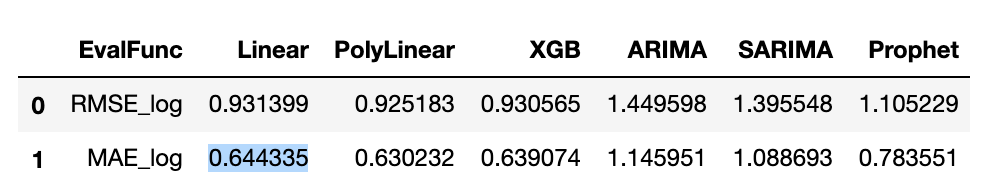

In [86]:
# Evalation for the prediction of validation data based on original
Eval_table_original

,EvalFunc,Linear,PolyLinear,XGB,ARIMA,SARIMA,Prophet,Ridge,Lasso
0,RMSE_Yen/kWh,4.910505,5.331288,5.821191,6.361744,6.256448,6.153208,4.910551,4.910505
1,MAE_Yen/kWh,2.065430,2.049748,2.406201,3.629738,3.429830,2.471364,2.065435,2.065430


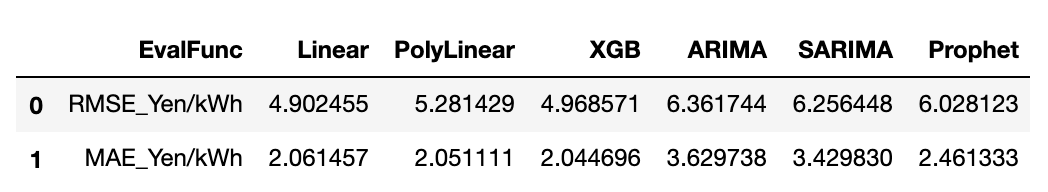

# 当Noteの結論 (予定)

- 自己回帰のパフォーマンスと機械学習のパフォーマンスを比べてみる
- ここでのパフォーマンスをベンチマークとして、別のNoteで特徴量を加えた機械学習の改善度合いを見てみる
- さらにどの特徴量が特に重要であるかも確認する
- 注目したい点は、out-of-sampleのパフォーマンスと価格スパイクのカバー度合い